<a href="https://colab.research.google.com/github/JoelBenesh/marked-beetle-analysis-1/blob/main/NRCan2_Dorsal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
os.chdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")

In [4]:
for filename in filenames:
  if "light" in filename:
    filenames.remove(filename)

dataframe = []
for filename in filenames:
  if ("Papered" or "NoPapered") and not "v" in filename:
    dataframe.append([filename])

len(dataframe)

for item in dataframe:
  if "NoPapered" in item[0]:
    item.append("unmarked")
  else:
    item.append("marked")

df = pd.DataFrame(data=dataframe,columns=["filename","category"])
df["category"].value_counts()
df

,filename,category
0,PaperedControl21d.tif,marked
1,PaperedControl22d.tif,marked
2,PaperedControl23d.tif,marked
3,PaperedControl24d.tif,marked
4,PaperedControl25d.tif,marked
...,...,...
504,PaperedControl16d.tif,marked
505,PaperedControl17d.tif,marked
506,PaperedControl18d.tif,marked
507,PaperedControl19d.tif,marked


In [5]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [6]:
def threscrop(img):
  #convert to grayscale and apply adaptive thresholding
  grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #return thresh

  #detect edges and crop the image
  canny = cv2.Canny(thresh, 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  #cropped_img = img[y1:y2, x1:x2]
  cropped_img = cv2.resize(img[y1:y2, x1:x2], (600,600))


  return cropped_img

In [7]:
def crop(img):

  blurred = cv2.blur(img, (3,3))
  canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

## crop the region
  cropped = img[y1:y2, x1:x2]
  resized=cv2.resize(cropped, (600,600))
  #cv2.imwrite("cropped.png", cropped)
  return resized

  #tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
  #cv2.imshow("tagged", tagged)
  #cv2.waitKey()

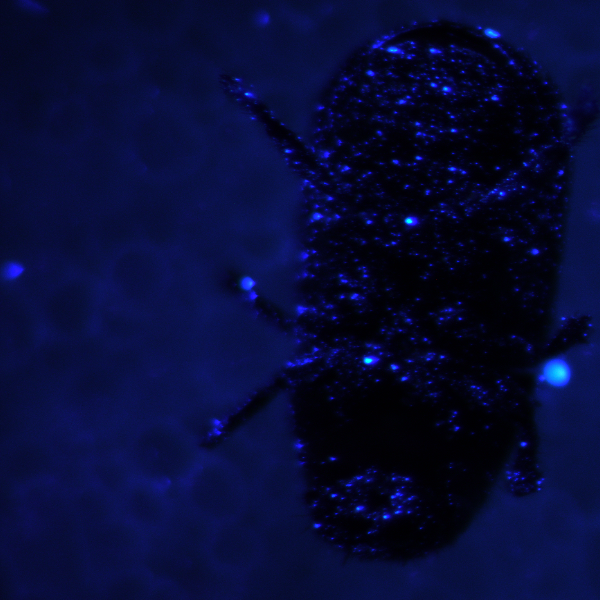

(600, 600, 3)

In [8]:
cv2_imshow(threscrop(image))
threscrop(image).shape

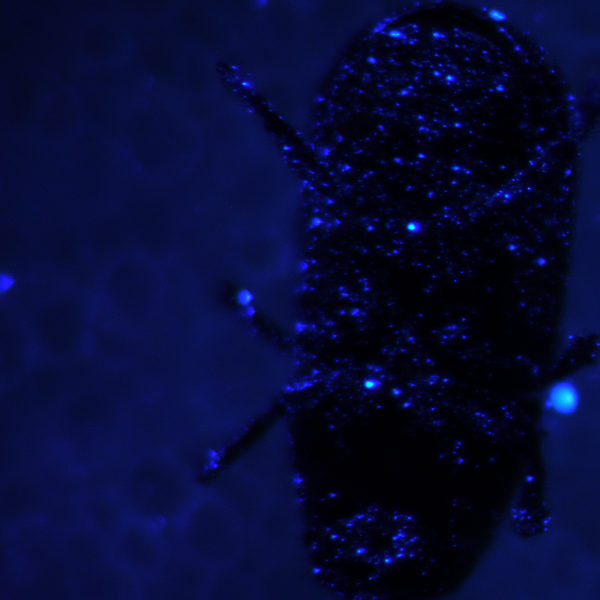

(600, 600, 3)

In [9]:
cv2_imshow(crop(image))
crop(image).shape

In [10]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [11]:
tmp_df = df.sample(9)
tmp_df

,filename,category
398,PinkPapierMacheMixed18d.tif,marked
66,PaperedTransparent8d.tif,marked
185,PaperedControlTest80d.tif,marked
490,NoPaperedGreen2d.tif,unmarked
403,PinkPapierMacheMixed23d.tif,marked
497,NoPaperedGreen9d.tif,unmarked
372,PaperedMixed42d.tif,marked
69,PaperedTransparent11d.tif,marked
227,NoPaperedGreen24d.tif,unmarked


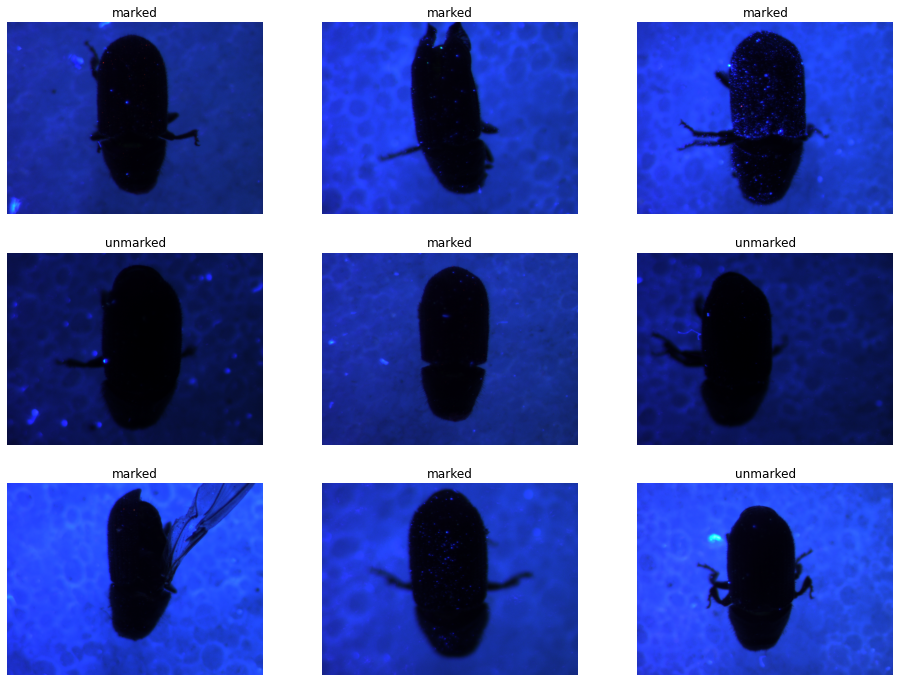

In [12]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [13]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [14]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [15]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [16]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    )

In [17]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 453 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [18]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 51 validated image filenames belonging to 2 classes.


In [19]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE))

    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

258088960/258076736 [==============================] - 3s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
____________________

In [20]:
EPOCHS = 10
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [21]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [22]:
results = Model_fit()

Epoch 1/10
30/30 [==============================] - 1639s 54s/step - loss: 0.8921 - accuracy: 0.7374 - val_loss: 0.4537 - val_accuracy: 0.8444


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
30/30 [==============================] - 1488s 50s/step - loss: 1.0938 - accuracy: 0.7763 - val_loss: 0.4380 - val_accuracy: 0.8667
Epoch 3/10
30/30 [==============================] - 1570s 52s/step - loss: 1.0857 - accuracy: 0.7689 - val_loss: 0.3468 - val_accuracy: 0.8444
Epoch 4/10
30/30 [==============================] - 1566s 52s/step - loss: 0.8634 - accuracy: 0.7831 - val_loss: 0.3918 - val_accuracy: 0.8667
Epoch 5/10
30/30 [==============================] - 1571s 52s/step - loss: 0.9199 - accuracy: 0.7900 - val_loss: 0.4038 - val_accuracy: 0.7778

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
30/30 [==============================] - 1621s 54s/step - loss: 0.6163 - accuracy: 0.8059 - val_loss: 0.3272 - val_accuracy: 0.8444
Epoch 7/10
30/30 [==============================] - 1567s 52s/step - loss: 0.4981 - accuracy: 0.8539 - val_loss: 0.3067 - val_accuracy: 0.8667
Epoch 8/10
30/30 [==============================] - 1575s 52

In [23]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8721461296081543
Val_Cat-Acc:  0.8888888955116272


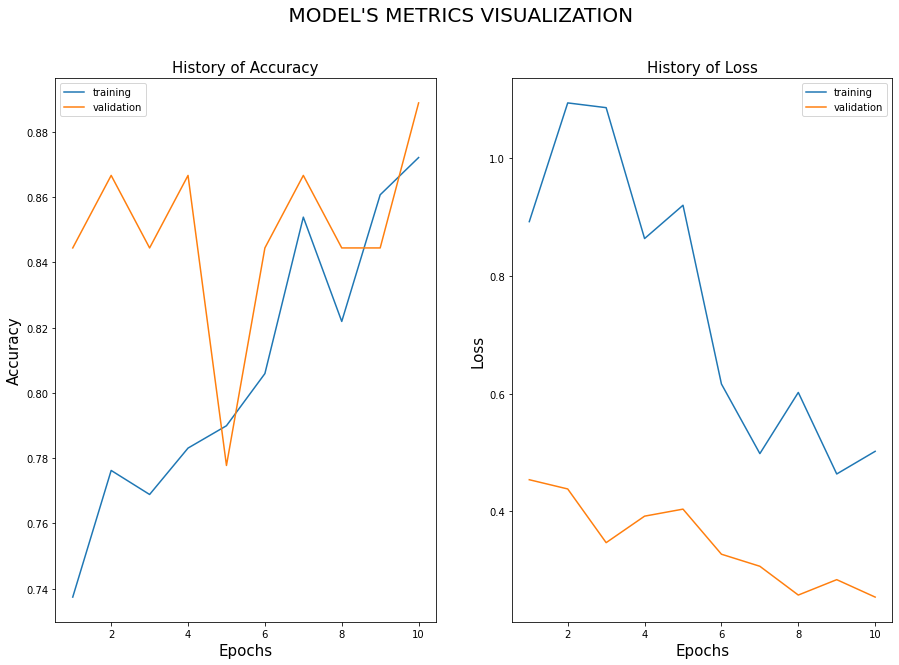

In [24]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [26]:
final_model = keras.models.load_model('best_model.h5')

In [27]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
500,PaperedControl12d.tif,marked
491,NoPaperedGreen3d.tif,unmarked
226,NoPaperedGreen39d.tif,unmarked
152,PaperedTransparent94d.tif,marked
44,PaperedControl65d.tif,marked
201,NoPaperedGreen20d.tif,unmarked
356,PaperedMixed26d.tif,marked
180,PinkPapierMache22d.tif,marked
255,NoPaperedGreen65d.tif,unmarked
213,NoPaperedGreen35d.tif,unmarked


In [28]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [29]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
500,PaperedControl12d.tif,marked,marked
491,NoPaperedGreen3d.tif,unmarked,unmarked
226,NoPaperedGreen39d.tif,unmarked,marked
152,PaperedTransparent94d.tif,marked,unmarked
44,PaperedControl65d.tif,marked,unmarked
201,NoPaperedGreen20d.tif,unmarked,marked
356,PaperedMixed26d.tif,marked,marked
180,PinkPapierMache22d.tif,marked,marked
255,NoPaperedGreen65d.tif,unmarked,unmarked
213,NoPaperedGreen35d.tif,unmarked,unmarked
